In [18]:
import torch
import time
import sys
import copy
import random
import hashlib
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from dataset import AsyncSubsetFineWebEdu2Loader  # Custom dataset module
from transformers import GPT2LMHeadModel, AutoTokenizer, GPT2Config
import asyncio
import logging
import matplotlib.pyplot as plt
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def get_indices(model, seed, compression:int, device:str):
    if compression == 1:
        return {name: torch.arange(param.numel()).long().cpu() for name, param in model.named_parameters()}
    
    seed = int(hashlib.md5(str(seed).encode('utf-8')).hexdigest(), 16) % (2**32)
    rng = np.random.default_rng(seed)
    result = {}
    for name, param in model.named_parameters():
        # Randomly select indices based on the compression factor
        num_indices = max(1, int(param.numel() // compression))
        indices = rng.choice(param.numel(), size=num_indices, replace=False)
        result[name] = torch.from_numpy(indices).long().to(device)
    return result

async def run_sim(base_model, miner_models, optimizers, tokenizer, compression):
    """
    Run a simulation step to compute cosine similarities between miner updates and base model gradients.

    Args:
        base_model (nn.Module): The base model.
        miner_models (list of nn.Module): List of miner models.
        optimizers (list of Optimizer): List of optimizers for the miner models.
        tokenizer (Tokenizer): Tokenizer used for the models.

    Returns:
        similarity (list of float): List of total cosine similarities for each miner model.
    """
    offset = int(time.time())
    similarity = []
    divergence = []
    indices = get_indices(base_model, random.randint(0, 1000), compression=compression, device = base_model.device)
    
    # Compute average.
    averages = {}
    for name, param in base_model.named_parameters():
        idx = indices[name]        
        avg_param = torch.zeros_like(param).view(-1)[idx]
        for miner_model in miner_models:
            miner_param = dict(miner_model.named_parameters())[name]
            avg_param += miner_param.view(-1)[idx]
        avg_param /= len(miner_models)
        averages[name] = avg_param
        
    # Set average in base model.
    for name, param in base_model.named_parameters():
        idx = indices[name].to(param.data.device)
        avg_param = averages[name]
        avg_param = avg_param.to(param.data.dtype)
        avg_param = avg_param.to(param.data.device)
        param.data.view(-1)[ idx ] = avg_param.clone()
        if param.data.view(-1)[ idx ].norm().item() != avg_param.norm().item():
            print(name,avg_param.norm().item(),param.data.view(-1)[ idx ].norm().item(), idx)
            sys.exit()
    
    # Set average in miner models.
    for miner_model in miner_models:
        for name, param in miner_model.named_parameters():
            idx = indices[name]
            avg_param = averages[name]
            avg_param = avg_param.to(param.data.dtype)
            avg_param = avg_param.to(param.data.device)
            param.data.view(-1)[ idx ] = avg_param.clone()

    # Assert that all the values under the indices are the same for base_model and all models
    for name, param in base_model.named_parameters():
        if name not in indices: continue
        base_values = param.view(-1)[indices[name]]
        for miner_model in miner_models:
            # Access miner model parameters directly
            miner_param = dict(miner_model.named_parameters())[name]
            miner_values = miner_param.view(-1)[indices[name]]
            if not torch.allclose(base_values, miner_values, atol=1e-4):
                print(f"Difference for {name}: {base_values - miner_values}")

    # Training phase for miner models
    for i in tqdm(range(len(miner_models)), desc="Training miners"):
        # Each miner trains on its own unique page
        pages = await AsyncSubsetFineWebEdu2Loader.next_pages(
            offset = offset,
            n_pages=1,
            seed=i
        )
        dataset = await AsyncSubsetFineWebEdu2Loader.create(
            batch_size=2,
            sequence_length=1024,
            pages_info=pages,
            tokenizer=tokenizer
        )

        # Zero gradients for the current miner model
        miner_models[i].zero_grad()

        # Train the miner model on its dataset
        for batch in dataset:
            input_ids = torch.tensor(batch, dtype=torch.long).to(miner_models[i].device)
            labels = input_ids.clone()
            labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)

            # Forward pass with mixed precision
            with torch.amp.autocast(device_type=miner_models[i].device.type, dtype=torch.bfloat16):
                outputs = miner_models[i](input_ids=input_ids, labels=labels)
            # Backward pass
            outputs.loss.backward()

        # Update the miner model parameters
        optimizers[i].step()
        optimizers[i].zero_grad()

    # Validation phase: compute similarities
    
    eval_model_i = random.choice( list(range(len(miner_models))))
    eval_model = miner_models[ eval_model_i ]
    # Decide whether to use a random page or the same page the miner trained on
    is_random = True if eval_model_i % 2 != 0 else False
    seed = random.randint(0, 10000) if is_random else eval_model_i

    # Load validation data
    pages = await AsyncSubsetFineWebEdu2Loader.next_pages(
        offset=offset,
        n_pages=1,
        seed=seed
    )
    dataset = await AsyncSubsetFineWebEdu2Loader.create(
        batch_size=2,
        sequence_length=1024,
        pages_info=pages,
        tokenizer=tokenizer
    )

    # Zero gradients for the base model
    base_model.zero_grad()

    # Compute gradients on the base model
    for batch in dataset:
        input_ids = torch.tensor(batch, dtype=torch.long).to(base_model.device)
        labels = input_ids.clone()
        labels = torch.where(labels == tokenizer.pad_token_id, -100, labels)

        # Forward pass with mixed precision
        with torch.amp.autocast(device_type=base_model.device.type, dtype=torch.bfloat16):
            outputs = base_model(input_ids=input_ids, labels=labels)
        # Backward pass
        outputs.loss.backward()

    # Compute cosine similarity between the miner's update and the base model's gradient
    total_sim = 0.0
    total_divergence = 0.0
    for name, param in base_model.named_parameters():
        if param.grad is None:
            continue  # Skip parameters without gradients
        
        idxs = indices[name].clone().detach().to(base_model.device)

        # Get the gradient from the base model
        g = param.grad.view(-1).clone().detach().to(base_model.device)

        # Get the parameter difference (delta) between the miner model and the base model
        p1 = eval_model.state_dict()[name].view(-1).clone().detach().to(base_model.device)
        p2 = param.data.view(-1).clone().detach().to(base_model.device)
        delta = p1 - p2

        # Compute the cosine similarity between delta and gradient
        sim = torch.nn.functional.cosine_similarity(-delta[idxs], g[idxs], dim=0).item()
        weight = p1.data.view(-1)[idxs].norm().item() + 1e-8
        total_sim += weight * sim
        total_divergence += delta[idxs].norm().item()        

    # Return the similarities
    logger.info(f'eval_model_i: {eval_model_i}, total_sim: {total_sim}, total_divergence: {total_divergence}')
    return eval_model_i, total_sim


In [20]:
async def main(n_steps:int = 2 , n_models: int = 2, device: str = 'cuda:4', compression:int = 1, pretrained: bool = False):
    """
    Main function to run the simulation over multiple steps.
    """
    # Load the base model
    logger.info("Loading base model...")
    if pretrained:
        base_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    else:
        base_model = GPT2LMHeadModel(config=GPT2Config()).to(device)

    # Load the miner models
    logger.info("Loading miner models...")
    miner_models = [GPT2LMHeadModel(config=GPT2Config()).to(device) for _ in range(n_models)]
    for m in miner_models:
        m.load_state_dict(base_model.state_dict())

    # Create optimizers for miner models
    optimizers = []
    for i in range(n_models):
        optimizers.append(optim.AdamW(
            miner_models[i].parameters(),
            lr=5e-5,  # Peak learning rate
            betas=(0.9, 0.95),  # B1 and B2
            weight_decay=0.1,  # Weight decay
            foreach=True,  # More memory usage, but faster
        ))

    # Load the tokenizer
    logger.info("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained('gpt2', verbose=False, clean_up_tokenization_spaces=True)
    tokenizer.pad_token = tokenizer.eos_token  # Set pad token

    # Run the simulation for multiple steps
    history = []
    scores = [ 0 for i in range(n_models) ] 
    for step in range(n_steps):
        logger.info(f"Starting simulation step {step+1}/{n_steps}...")
        uid, score = await run_sim(base_model, miner_models, optimizers, tokenizer, compression)
        scores[uid] = score 
        history.append( copy.deepcopy( scores) )
    
    # Plot the history with a line for each index
    import matplotlib.pyplot as plt
    history = list(zip(*history))  # Transpose the history to get scores for each model
    for i, model_scores in enumerate(history):
        plt.plot(model_scores, label=f'Model {i}')
    plt.xlabel('Simulation Step')
    plt.ylabel('Score')
    plt.title('Scores History')
    plt.legend()
    plt.show()

   


INFO:__main__:Loading base model...
INFO:__main__:Loading miner models...
INFO:__main__:Loading tokenizer...
INFO:__main__:Starting simulation step 1/100...
Training miners: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]
INFO:__main__:eval_model_i: 1, total_sim: 39.440262395541076, total_divergence: 0.208135675828089
INFO:__main__:Starting simulation step 2/100...
Training miners: 100%|██████████| 5/5 [00:13<00:00,  2.66s/it]
INFO:__main__:eval_model_i: 1, total_sim: 65.97816870404402, total_divergence: 0.1486485832440394
INFO:__main__:Starting simulation step 3/100...
Training miners: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]
INFO:__main__:eval_model_i: 0, total_sim: 105.06933508619271, total_divergence: 0.12590003192599397
INFO:__main__:Starting simulation step 4/100...
Training miners: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]
INFO:__main__:eval_model_i: 1, total_sim: 59.3265744743363, total_divergence: 0.11283473014918854
INFO:__main__:Starting simulation step 5/100...
Train

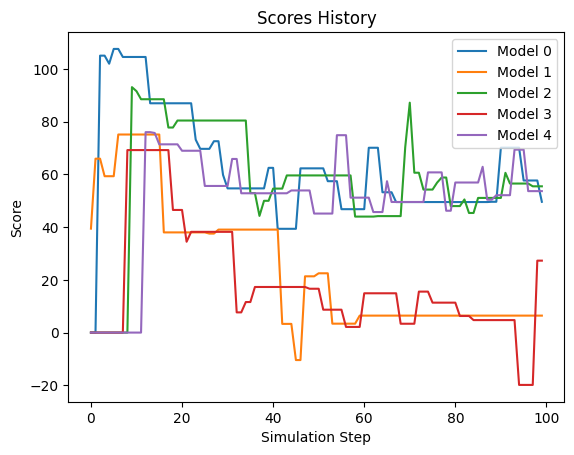

In [25]:
await main( n_steps = 100, n_models = 5, device = 'cuda:4', compression = 300, pretrained = True)